In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping

In [45]:
cancer_dir = Path("data/unhealthy")
normal_dir = Path("data/healthy")

classes = ['normal', 'cancer']

In [46]:
filepaths, labels = [], []
for dir_path, label in zip([normal_dir, cancer_dir], classes):
    if not dir_path.exists():
        print(f"Directory not found: {dir_path}")
        continue
    for file in dir_path.glob("*"):
        filepaths.append(str(file))
        labels.append(label)

print(f"Found {len(filepaths)} files. Labels: {dict(pd.Series(labels).value_counts())}")


Found 6512 files. Labels: {'cancer': np.int64(5504), 'normal': np.int64(1008)}


In [47]:
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
df

,filepaths,labels
0,data\healthy\WBC-Benign-001.jpg,normal
1,data\healthy\WBC-Benign-002.jpg,normal
2,data\healthy\WBC-Benign-003.jpg,normal
3,data\healthy\WBC-Benign-004.jpg,normal
4,data\healthy\WBC-Benign-005.jpg,normal
...,...,...
6507,data\unhealthy\WBC-unhealthy_995.jpg,cancer
6508,data\unhealthy\WBC-unhealthy_996.jpg,cancer
6509,data\unhealthy\WBC-unhealthy_997.jpg,cancer
6510,data\unhealthy\WBC-unhealthy_998.jpg,cancer


labels
cancer    5504
normal    1008
Name: count, dtype: int64


C:\Users\vansh\AppData\Local\Temp\ipykernel_9696\1931242662.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='labels', palette='viridis')


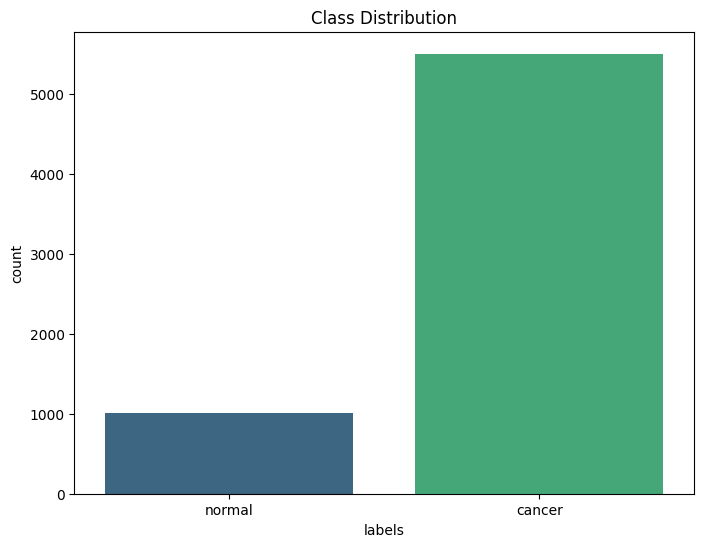

In [48]:
print(df['labels'].value_counts())
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='labels', palette='viridis')
plt.title("Class Distribution")
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
sample_images = df.sample(8)
for i, filepath in enumerate(sample_images['filepaths']):
    img = tf.keras.utils.load_img(filepath, target_size=(128, 128))
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(sample_images['labels'].iloc[i])
    plt.axis('off')
plt.suptitle("Sample Images from Dataset")
plt.tight_layout()
plt.show()

In [49]:
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['labels'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['labels'], random_state=42)


In [50]:
image_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train = image_gen.flow_from_dataframe(
    dataframe=train_df, x_col="filepaths", y_col="labels",
    target_size=(128, 128), class_mode="categorical", batch_size=32, shuffle=True, workers=4)

val = image_gen.flow_from_dataframe(
    dataframe=val_df, x_col="filepaths", y_col="labels",
    target_size=(128, 128), class_mode="categorical", batch_size=32, shuffle=False, workers=4)

test = image_gen.flow_from_dataframe(
    dataframe=test_df, x_col="filepaths", y_col="labels",
    target_size=(128, 128), class_mode="categorical", batch_size=32, shuffle=False, workers=4)


Found 3646 validated image filenames belonging to 2 classes.
Found 912 validated image filenames belonging to 2 classes.
Found 1954 validated image filenames belonging to 2 classes.


In [51]:
train_X, train_y = np.vstack([train[i][0] for i in range(len(train))]), np.vstack([train[i][1] for i in range(len(train))])
val_X, val_y = np.vstack([val[i][0] for i in range(len(val))]), np.vstack([val[i][1] for i in range(len(val))])


In [52]:

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Reshape((1, -1))(x)  

x = LSTM(64)(x) 
x = Dropout(0.2)(x)  
x = Dense(128, activation='relu')(x)
output = Dense(2, activation='softmax')(x) 

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [53]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [54]:
history = model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 42s 320ms/step - accuracy: 0.8577 - loss: 0.3307 - val_accuracy: 0.9561 - val_loss: 0.1152
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 39s 342ms/step - accuracy: 0.9432 - loss: 0.1409 - val_accuracy: 0.9649 - val_loss: 0.0913
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 35s 306ms/step - accuracy: 0.9546 - loss: 0.1041 - val_accuracy: 0.9660 - val_loss: 0.0817
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 32s 285ms/step - accuracy: 0.9776 - loss: 0.0584 - val_accuracy: 0.9616 - val_loss: 0.0926
Epoch 5/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 34s 297ms/step - accuracy: 0.9701 - loss: 0.0760 - val_accuracy: 0.9682 - val_loss: 0.0918
Epoch 6/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 33s 285ms/step - accuracy: 0.9815 - loss: 0.0463 - val_accuracy: 0.9704 - val_loss: 0.0831


In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
test_X, test_y = np.vstack([test[i][0] for i in range(len(test))]), np.vstack([test[i][1] for i in range(len(test))])
test_loss, test_accuracy = model.evaluate(test_X, test_y)
print(f"Test Accuracy: {test_accuracy:.2f}")

62/62 ━━━━━━━━━━━━━━━━━━━━ 15s 236ms/step - accuracy: 0.9509 - loss: 0.1247
Test Accuracy: 0.96


62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 260ms/step


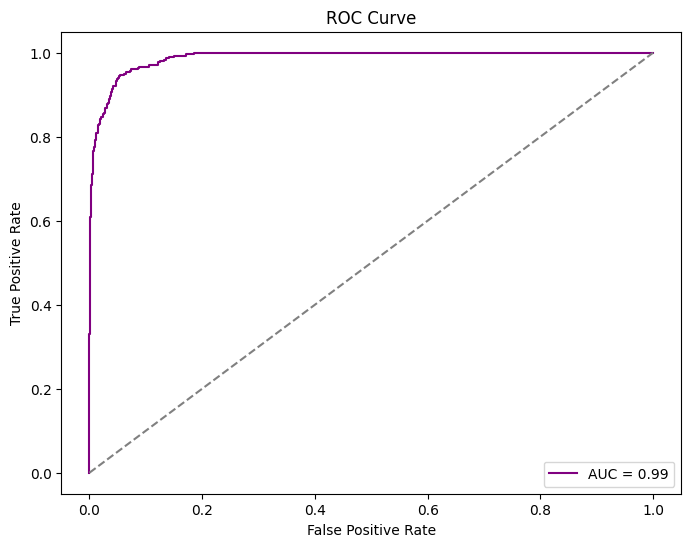

In [56]:
y_pred_probs = model.predict(test_X)
y_pred = np.argmax(y_pred_probs, axis=-1)
y_true = np.argmax(test_y, axis=-1)

fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs[:, 1])
roc_auc = roc_auc_score(y_true, y_pred_probs[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

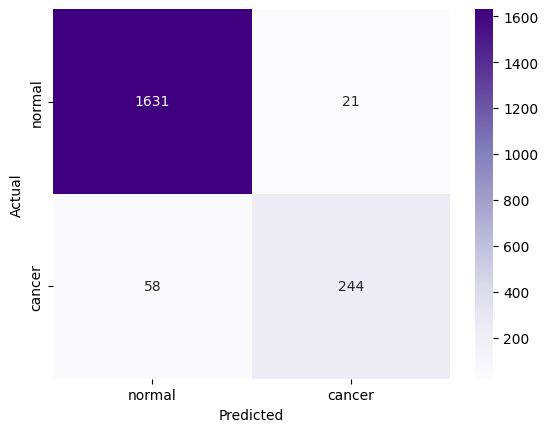

In [57]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(pd.DataFrame(cm, index=classes, columns=classes), annot=True, cmap="Purples", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()